# Projeto ADC

##### Imports

In [ ]:
import networkx as nx
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

#### Function to load the graph

In [2]:
def load_graph_from_edgelist(filepath):
    G = nx.Graph()
    
    with open(filepath, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            
            try:
                parts = list(map(int, line.strip().split()))
                
                if len(parts) > 1:
                    for to_node in parts[1:]:
                        G.add_edge(parts[0], to_node)
            except ValueError:
                continue
    
    return G

#### Function to load the communities

In [3]:
def load_communities(filepath):
    communities = defaultdict(list)
    
    with open(filepath, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            
            try:
                parts = list(map(int, line.strip().split()))
                
                if len(parts) > 1:
                    community_id = parts[0]
                    nodes = parts[1:]
                    
                    for node in nodes:
                        communities[node].append(community_id)
            except ValueError:
                continue
    
    return communities

In [4]:
# Paths to your files
graph_filepath = 'com-youtube.ungraph.txt'
community_filepath = 'com-youtube.all.cmty.txt'

# Load graph
# Load graph
G = load_graph_from_edgelist(graph_filepath)

# Load communities
node_communities = load_communities(community_filepath)

# Add community information to the graph
nx.set_node_attributes(G, {node: {'communities': comms} for node, comms in node_communities.items()}, 'communities')

# Print some basic information
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Number of nodes with community info: {len(node_communities)}")

Number of nodes: 1134890
Number of edges: 2987624
Number of nodes with community info: 48907


In [13]:
import networkx as nx
from collections import defaultdict
import random
import pickle

def load_graph_from_edgelist(filepath):
    G = nx.Graph()
    
    with open(filepath, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            
            try:
                parts = list(map(int, line.strip().split()))
                
                if len(parts) > 1:
                    for to_node in parts[1:]:
                        G.add_edge(parts[0], to_node)
            except ValueError:
                continue
    
    return G

def load_communities(filepath):
    communities = defaultdict(list)
    
    with open(filepath, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            
            try:
                parts = list(map(int, line.strip().split()))
                
                if len(parts) > 1:
                    community_id = parts[0]
                    nodes = parts[1:]
                    
                    for node in nodes:
                        communities[community_id].append(node)
            except ValueError:
                continue
    
    return communities

graph_filepath = 'com-youtube.ungraph.txt'
community_filepath = 'com-youtube.all.cmty.txt'

G = load_graph_from_edgelist(graph_filepath)
communities = load_communities(community_filepath)

# Ordenar as comunidades pelo tamanho
sorted_communities = sorted(communities.items(), key=lambda x: len(x[1]))

# Definir limites para escolher comunidades
MIN_NODES = 10
MAX_NODES = 20000

selected_nodes = set()
for community_id, nodes in sorted_communities:
    if MIN_NODES <= len(nodes) <= MAX_NODES:
        selected_nodes.update(nodes)
    if len(selected_nodes) >= MAX_NODES:
        break

subgraph = G.subgraph(selected_nodes).copy()

print(f"Número de nós no subgrafo inicial: {subgraph.number_of_nodes()}")
print(f"Número de arestas no subgrafo inicial: {subgraph.number_of_edges()}")

if subgraph.number_of_nodes() > 0 and subgraph.number_of_edges() > 0:
    nx.write_edgelist(subgraph, 'subgraph.edgelist')
else:
    print("Nenhum subgrafo válido foi gerado. Verifique os parâmetros ou os dados.")

# Calcular métricas do subgrafo
subgraph_acc = nx.average_clustering(subgraph)
subgraph_degree_assortativity = nx.degree_assortativity_coefficient(subgraph)
subgraph_average_degree = sum(dict(subgraph.degree()).values()) / subgraph.number_of_nodes()
subgraph_density = nx.density(subgraph)
subgraph_diameter = nx.diameter(subgraph) if nx.is_connected(subgraph) else 'Subgrafo não conectado'

# Imprimir as métricas
print("Métricas do subgrafo inicial:")
print(f"  - Average Clustering Coefficient: {subgraph_acc}")
print(f"  - Degree Assortativity Coefficient: {subgraph_degree_assortativity}")
print(f"  - Average Degree: {subgraph_average_degree}")
print(f"  - Density: {subgraph_density}")
print(f"  - Diameter: {subgraph_diameter}")

subgraph_nodes = set(selected_nodes)  # Inicialmente contém os nós das comunidades selecionadas

# 2. Aplicar PageRank-based Sampling para selecionar nós importantes
def pagerank_sampling(graph, num_nodes=40000):
    pagerank_scores = nx.pagerank(graph)
    sorted_nodes = sorted(pagerank_scores, key=pagerank_scores.get, reverse=True)
    return set(sorted_nodes[:num_nodes])

pagerank_nodes = pagerank_sampling(G, num_nodes=15000)
subgraph_nodes.update(pagerank_nodes)
print(f"Número de nós após PageRank Sampling: {len(subgraph_nodes)}")

# 3. Aplicar Snowball Sampling para expandir conexões entre comunidades
def snowball_sampling(graph, start_node, depth=2, max_nodes=30000):
    sampled_nodes = set([start_node])
    frontier = [start_node]
    
    while frontier and len(sampled_nodes) < max_nodes:
        new_frontier = []
        for node in frontier:
            neighbors = list(graph.neighbors(node))
            new_frontier.extend(neighbors)
            sampled_nodes.update(neighbors)
            if len(sampled_nodes) >= max_nodes:
                break
        frontier = new_frontier
    
    return sampled_nodes

# Selecionar nós na borda do subgrafo para iniciar Snowball Sampling
boundary_nodes = [node for node in subgraph_nodes if len(set(G.neighbors(node)) - subgraph_nodes) > 0]
selected_boundary_nodes = random.sample(boundary_nodes, min(10, len(boundary_nodes)))
snowball_nodes = set()
for node in selected_boundary_nodes:
    snowball_nodes.update(snowball_sampling(G, node, depth=2, max_nodes=100))

# Adicionar nós do Snowball Sampling ao subgrafo
subgraph_nodes.update(snowball_nodes)
print(f"Número de nós após Snowball Sampling: {len(subgraph_nodes)}")

# 4. Aplicar BFS para garantir que a componente seja conectada
def bfs_sampling(graph, start_node, max_nodes=50000):
    visited = set([start_node])
    queue = [start_node]
    
    while queue and len(visited) < max_nodes:
        node = queue.pop(0)
        neighbors = list(graph.neighbors(node))
        for neighbor in neighbors:
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)
                if len(visited) >= max_nodes:
                    break
    
    return visited

bfs_start_node = random.choice(list(subgraph_nodes))
bfs_nodes = bfs_sampling(G, bfs_start_node, max_nodes=15000)
subgraph_nodes.update(bfs_nodes)
print(f"Número de nós após BFS Sampling: {len(subgraph_nodes)}")

# 5. Aplicar Random Walk Sampling para garantir diversidade
def random_walk_sampling(graph, start_node, steps=200):
    sampled_nodes = set()
    current_node = start_node
    
    for _ in range(steps):
        neighbors = list(graph.neighbors(current_node))
        if neighbors:
            next_node = random.choice(neighbors)
            sampled_nodes.add(next_node)
            current_node = next_node
        else:
            break
    
    return sampled_nodes

initial_nodes = random.sample(list(subgraph_nodes), min(5, len(subgraph_nodes)))
random_walk_nodes = set()
for node in initial_nodes:
    random_walk_nodes.update(random_walk_sampling(G, node, steps=500))

subgraph_nodes.update(random_walk_nodes)
print(f"Número de nós após Random Walk Sampling: {len(subgraph_nodes)}")

# Criar um subgrafo a partir dos nós coletados
final_subgraph = G.subgraph(subgraph_nodes).copy()

print(f"Número de nós no subgrafo final: {final_subgraph.number_of_nodes()}")
print(f"Número de arestas no subgrafo final: {final_subgraph.number_of_edges()}")

# Calcular métricas do subgrafo final
final_subgraph_acc = nx.average_clustering(final_subgraph)
final_subgraph_degree_assortativity = nx.degree_assortativity_coefficient(final_subgraph)
final_subgraph_average_degree = sum(dict(final_subgraph.degree()).values()) / final_subgraph.number_of_nodes()
final_subgraph_density = nx.density(final_subgraph)
final_subgraph_diameter = nx.diameter(final_subgraph) if nx.is_connected(final_subgraph) else 'Subgrafo não conectado'

print("Métricas do subgrafo final:")
print(f"  - Average Clustering Coefficient: {final_subgraph_acc}")
print(f"  - Degree Assortativity Coefficient: {final_subgraph_degree_assortativity}")
print(f"  - Average Degree: {final_subgraph_average_degree}")
print(f"  - Density: {final_subgraph_density}")
print(f"  - Diameter: {final_subgraph_diameter}")

# Salvar variáveis importantes usando pickle
with open('saved_data.pkl', 'wb') as f:
    pickle.dump({
        'G': G,
        'subgraph': subgraph,
        'final_subgraph': final_subgraph,
        'communities': communities,
        'sorted_communities': sorted_communities,
        'selected_nodes': selected_nodes,
        'subgraph_nodes': subgraph_nodes
    }, f)

print("Variáveis importantes foram salvas com sucesso usando pickle.")

Número de nós no subgrafo inicial: 20072
Número de arestas no subgrafo inicial: 118185
Métricas do subgrafo inicial:
  - Average Clustering Coefficient: 0.20893442431351494
  - Degree Assortativity Coefficient: 0.02613864362885644
  - Average Degree: 11.776106018333998
  - Density: 0.0005867224362679487
  - Diameter: Subgrafo não conectado
Número de nós após PageRank Sampling: 32318
Número de nós após Snowball Sampling: 40138
Número de nós após BFS Sampling: 49953
Número de nós após Random Walk Sampling: 50986
Número de nós no subgrafo final: 50986
Número de arestas no subgrafo final: 594352
Métricas do subgrafo final:
  - Average Clustering Coefficient: 0.18932706318631218
  - Degree Assortativity Coefficient: -0.0539164435755376
  - Average Degree: 23.314321578472523
  - Density: 0.0004572780539074732
  - Diameter: Subgrafo não conectado
Variáveis importantes foram salvas com sucesso usando pickle.


#### Subsetting

Top 1000 largest communities with at least 3 nodes

In [14]:
######## Outro bloco de código para carregar as variáveis e o subgrafo ########
import pickle
import networkx as nx

# Carregar o subgrafo, as comunidades e a lista de nós salvos
with open('saved_data.pkl', 'rb') as f:
    saved_data = pickle.load(f)
    
final_subgraph = saved_data['final_subgraph']
communities = saved_data['communities']
subgraph_nodes = saved_data['subgraph_nodes']
G = saved_data['G']


# Verificar o subgrafo carregado
print(f"Número de nós no subgrafo carregado: {final_subgraph.number_of_nodes()}")
print(f"Número de arestas no subgrafo carregado: {final_subgraph.number_of_edges()}")


Número de nós no subgrafo carregado: 50986
Número de arestas no subgrafo carregado: 594352


#### Visualize subset

In [43]:
# Map each node to its community
node_to_community = {}
for comm_id, nodes in communities.items():
    for node in nodes:
        node_to_community[node] = comm_id

# Example: Adding community attribute
for node in final_subgraph.nodes():
    final_subgraph.nodes[node]['community'] = node_to_community.get(node, -1)

# Export to GML
nx.write_gml(final_subgraph, "graph_with_communities.gml")


#### Compute community metrics for subset

In [44]:
import networkx as nx

def compute_community_metrics(G, communities):
    metrics = []
    
    for i, (comm_number, community_nodes) in enumerate(communities.items()):
        # a comunidade tem de ter um 'formato válido'
        if not isinstance(community_nodes, list):
            print(f"Error: Community {comm_number} is not a valid list of nodes.")
            continue  
        
        # criar subgrafo da comunidade
        subgraph = G.subgraph(community_nodes)
        
        # ver se a comunidade é composta por nós isolados
        num_edges = subgraph.number_of_edges()
        
        if num_edges == 0:
            clustering = 0  
            density = 0     
            internal_edge_fraction = 0  
        else:
            # métricas
            clustering = nx.average_clustering(subgraph)
            density = nx.density(subgraph)
            internal_edges = num_edges
            total_edges = sum([G.degree(node) for node in community_nodes if node in G])
            internal_edge_fraction = internal_edges / total_edges if total_edges > 0 else 0
        
        metrics.append({
            "community_id": comm_number,
            "num_nodes": len(community_nodes),
            "clustering": clustering,
            "density": density,
            "internal_edge_fraction": internal_edge_fraction
        })

    return metrics

community_metrics = compute_community_metrics(final_subgraph, communities)


#### Measure influence of each node

In [30]:
# TODO: Muito lento para ~210k nodes

#### Compare results to full network

In [45]:
# Compute average metrics for the subset
subset_community_clustering = sum([m["clustering"] for m in community_metrics]) / len(community_metrics)
subset_community_density = sum([m["density"] for m in community_metrics]) / len(community_metrics)

# Compute full network metrics
full_clustering = nx.average_clustering(G)
full_density = nx.density(G)

print("Comparison of Metrics:")
print(f"Full Network Clustering Coefficient: {full_clustering}")
print(f"Subset Community Clustering Coefficient: {subset_community_clustering}")
print(f"Full Network Density: {full_density}")
print(f"Subset Community Density: {subset_community_density}")

KeyboardInterrupt: 

#### Visualize results
comunidades maiores -> menos coesas e menos densas <br>
comunidades menores -> mais coesas e mais densas <br>
isto sugere que comunidades maiores estão mais 'espalhadas' e têm conexões mais escassas provavelmente devido a serem mais diversas e ao facto de haver diferentes niveis de engagement dentro da comunidade

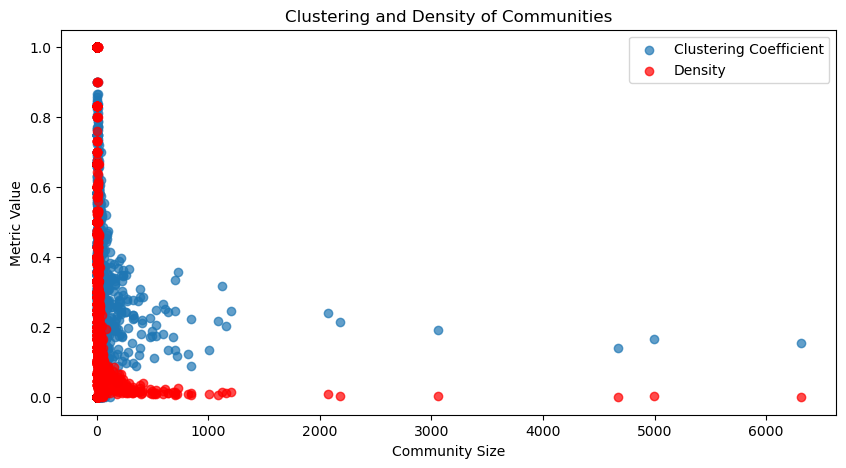

In [ ]:
df = pd.DataFrame(community_metrics)


plt.figure(figsize=(10, 5))
plt.scatter(df["num_nodes"], df["clustering"], label="Clustering Coefficient", alpha=0.7)
plt.scatter(df["num_nodes"], df["density"], label="Density", alpha=0.7, color="red")
plt.xlabel("Community Size")
plt.ylabel("Metric Value")
plt.title("Clustering and Density of Communities")
plt.legend()
plt.show()
